# **Setting & Introduction**

## **1. Github 연동**

In [1]:
""" github 연동 """
# !git clone https://github.com/ku-sungsukim/2025-LGElec-Day22.git ### colab 사용 시

' github 연동 '

## **2. About Jupyter Notebook**

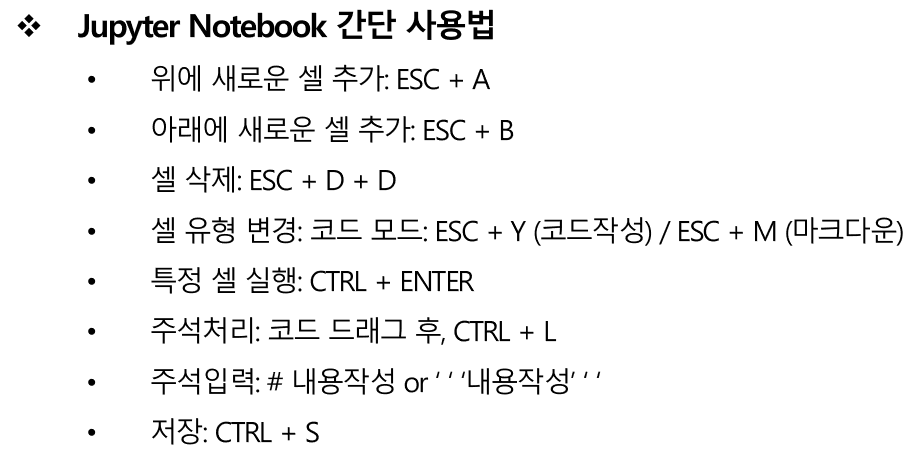

In [2]:
""" 설명 장표 불러오기 """
from IPython.display import Image
Image('image/1-Introduction2.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/1-Introduction2.PNG') ### colab 사용 시

## **[Data Balancing & XAI 실습 목차]**
 - (1) Data Balancing (1) - UnderSampling

 - (2) Data Balancing (2) - Oversampling 

 - ***(3) XAI √***

## **[XAI - Image 목차]**

  - LIME

  - SHAP

## **0. 모델링 환경 설정**

#### **0-1. 필요 패키지 불러오기**

In [3]:
""" 필요 패키지 설치 """
!pip install lime

In [4]:
""" 필요 패키지 설치 """
!pip install shap

In [5]:
""" 실습에 필요한 패키지 불러오기 """


""" 기본 연산과 관련된 패키지 """
import json
import numpy as np
import pandas as pd


""" 이미지 전처리 패키지 """
from skimage.segmentation import mark_boundaries


""" 모델링 및 성능 산출과 관련된 패키지"""
import torch
import torch.nn.functional as F
import torchvision.transforms as tf
from torchvision.models import vgg16, VGG16_Weights


""" XAI 패키지 """
import shap
shap.initjs()
from shap import TreeExplainer
from lime.lime_image import LimeImageExplainer


""" 시각화 패키지 """
import matplotlib.pyplot as plt


""" 경고 숨기기 """
import warnings
warnings.filterwarnings('ignore')

#### **0-2. 필요 함수 사전 정의**

In [6]:
""" (1) 이미지를 정규화하는 함수 """

def normalize(image):

    ### 픽셀값이 0~255면 0~1로 우선 변환
    if image.max() > 1:
        scaled_image = image/255.

    ### 데이터 정규화
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    scaled_image = (scaled_image - mean) / std

    ### torch에 맞게 차원 변경
    torch_image = torch.tensor(scaled_image.swapaxes(-1, 1).swapaxes(2, 3)).float() ### (N, H, W, C) --> (N, C, H, W)
    return torch_image

## **1. 실습 데이터셋 확보**

 - 데이터: ImageNet 데이터 (일상 이미지 데이터) 

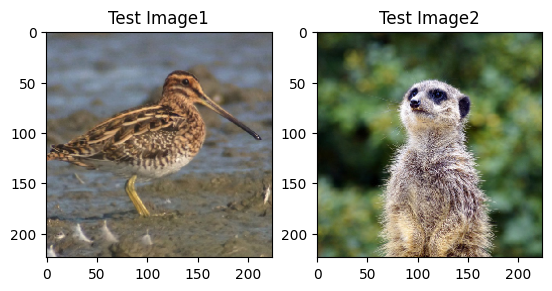

In [7]:
""" 데이터 불러오기 """

### 데이터 불러오기
X, y = shap.datasets.imagenet50()

### 시각화
test_imgs = X[[39, 41]]
plt.subplot(1, 2, 1)
plt.imshow(test_imgs[0] / 255.)
plt.title('Test Image1')

plt.subplot(1, 2, 2)
plt.imshow(test_imgs[1] / 255.) 
plt.title('Test Image2')
plt.show()

## **2. Base 모델 불러오기**

 - 학습 대신, 기존에 사전학습된 Weight를 활용

In [8]:
""" 사전학습된 모델 불러오기 """
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = vgg16(weights=VGG16_Weights.DEFAULT).to(device) ### ImageNet 데이터로 사전학습된 모델
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [9]:
""" 모델 예측값 산출 """
test_imgs_tensor = normalize(test_imgs).to(device) ### pytorch tensor로 변환
outputs = model(test_imgs_tensor) ### 예측
outputs.shape ### 2개 이미지가 1000개 Class에 대한 예측 결과

torch.Size([2, 1000])

In [10]:
""" Logit을 확률로 변환"""

### 확률로 변환
probs = F.softmax(outputs, dim=1)

### Top5 확률 확인
probs5 = probs.topk(5)
print(probs5)

torch.return_types.topk(
values=tensor([[9.9973e-01, 2.1338e-04, 5.3050e-05, 5.9460e-06, 2.1258e-07],
        [9.2091e-01, 7.8514e-02, 5.4812e-04, 1.2042e-05, 4.9361e-06]],
       device='cuda:0', grad_fn=<TopkBackward0>),
indices=tensor([[142, 140, 141, 139, 133],
        [299, 298, 336, 360, 356]], device='cuda:0'))


In [11]:
""" Class 정보 불러오기 """

### 경로 설정
class_dir = 'data/imagenet_class_index.json' ### 로컬 사용 시
# class_dir = '/content/2025-LGElec-Day22/data/imagenet_class_index.json' ### 로컬 사용 시

### ImageNet 이미지 데이터에 대응되는  Class 불러오기
with open(file=class_dir, mode='rt') as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))] ### label의 집합

idx2label

['tench',
 'goldfish',
 'great_white_shark',
 'tiger_shark',
 'hammerhead',
 'electric_ray',
 'stingray',
 'cock',
 'hen',
 'ostrich',
 'brambling',
 'goldfinch',
 'house_finch',
 'junco',
 'indigo_bunting',
 'robin',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water_ouzel',
 'kite',
 'bald_eagle',
 'vulture',
 'great_grey_owl',
 'European_fire_salamander',
 'common_newt',
 'eft',
 'spotted_salamander',
 'axolotl',
 'bullfrog',
 'tree_frog',
 'tailed_frog',
 'loggerhead',
 'leatherback_turtle',
 'mud_turtle',
 'terrapin',
 'box_turtle',
 'banded_gecko',
 'common_iguana',
 'American_chameleon',
 'whiptail',
 'agama',
 'frilled_lizard',
 'alligator_lizard',
 'Gila_monster',
 'green_lizard',
 'African_chameleon',
 'Komodo_dragon',
 'African_crocodile',
 'American_alligator',
 'triceratops',
 'thunder_snake',
 'ringneck_snake',
 'hognose_snake',
 'green_snake',
 'king_snake',
 'garter_snake',
 'water_snake',
 'vine_snake',
 'night_snake',
 'boa_constrictor',
 'rock_python',
 'Indian_cobr

In [12]:
""" 실제로 어떤 class로 예측했는지 확인 """

sample_idx = 0
array_prob = probs5[0][sample_idx].cpu().detach().numpy()
array_class = probs5[1][sample_idx].cpu().detach().numpy()
col = ['Probability', 'Index_number', 'Index_name']
pd.DataFrame(tuple((p,c, idx2label[c]) for p, c in zip(array_prob, array_class)), columns=col)

,Probability,Index_number,Index_name
0,9.997273e-01,142,dowitcher
1,2.133767e-04,140,red-backed_sandpiper
2,5.305047e-05,141,redshank
3,5.945970e-06,139,ruddy_turnstone
4,2.125813e-07,133,bittern


In [13]:
""" 실제로 어떤 class로 예측했는지 확인 """

sample_idx = 1
array_prob = probs5[0][sample_idx].cpu().detach().numpy()
array_class = probs5[1][sample_idx].cpu().detach().numpy()
col = ['Probability', 'Index_number', 'Index_name']
pd.DataFrame(tuple((p,c, idx2label[c]) for p, c in zip(array_prob, array_class)), columns=col)

,Probability,Index_number,Index_name
0,0.920911,299,meerkat
1,0.078514,298,mongoose
2,0.000548,336,marmot
3,0.000012,360,otter
4,0.000005,356,weasel


## **3. LIME**

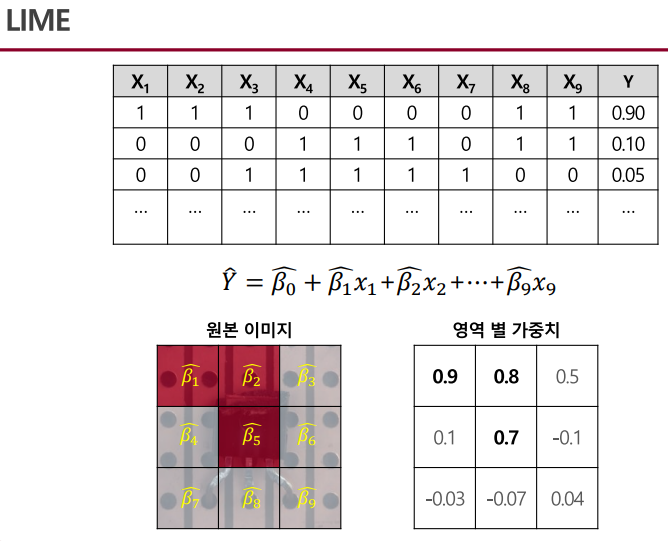

In [14]:
""" 설명 장표 불러오기 """
from IPython.display import Image
Image('image/9-XAI5.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/9-XAI5.PNG') ### colab 사용 시

In [15]:
""" LIME 모델링에 필요한 함수 정의  """

def batch_predict(images:list):

    ### torch type으로 데이터 변환
    sample_transform = tf.Compose([
    tf.ToPILImage(),
    tf.Resize((224,224)),
    tf.ToTensor(),
    tf.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225])
    ])
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch = torch.stack(tuple(sample_transform(i) for i in images), dim=0).to(device) ### 예측 결과를 dim=0 (batch 축)에 쌓기
    
    ### 모델이 각 이미지를 예측한 확률을 반환
    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy() 


In [16]:
""" 관측치 별 LIME 모델 학습 """
explainer = LimeImageExplainer()

explanation1 = explainer.explain_instance(np.array(test_imgs[0].astype(np.uint8)),
                                         classifier_fn=batch_predict,
                                         top_labels=1, ### 가장 높은 확률로 예측한 Class에 대해서만 시각화
                                         num_samples=1000) ### 최대 1000개에 대해서만 대체 모델 학습 

explanation2 = explainer.explain_instance(np.array(test_imgs[1].astype(np.uint8)),
                                         classifier_fn=batch_predict,
                                         top_labels=1, 
                                         num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

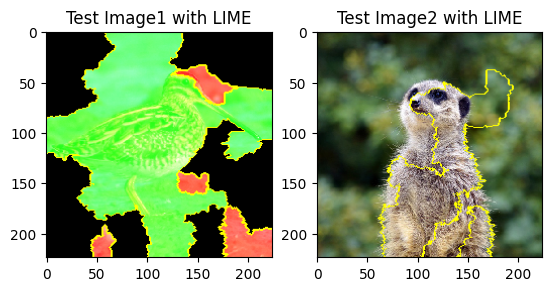

In [17]:
""" 결과 시각화 """

temp1, mask1 = explanation1.get_image_and_mask(explanation1.top_labels[0], 
                                               positive_only=False, ### 예측확률을 높이는데 기여한 것만 표시 --> 초록색: 확률증가 / 빨간색: 확률 하락
                                               num_features=20, ### 표시할 패치 개수 (top 영향도 기준 정렬)
                                               hide_rest=True) ### 관심 영역 외에 시각화 여부 (검은색 여부)
img_boundry1 = mark_boundaries(temp1/255.0, mask1)

temp2, mask2 = explanation2.get_image_and_mask(explanation2.top_labels[0], 
                                               positive_only=True, 
                                               num_features=5, 
                                               hide_rest=False)
img_boundry2 = mark_boundaries(temp2/255.0, mask2)

plt.subplot(1, 2, 1)
plt.imshow(img_boundry1)
plt.title('Test Image1 with LIME')

plt.subplot(1, 2, 2)
plt.imshow(img_boundry2)
plt.title('Test Image2 with LIME')
plt.show()

## **4. SHAP**

 - Shap Value를 추정하는 방법에 따라 여러 함수 존재

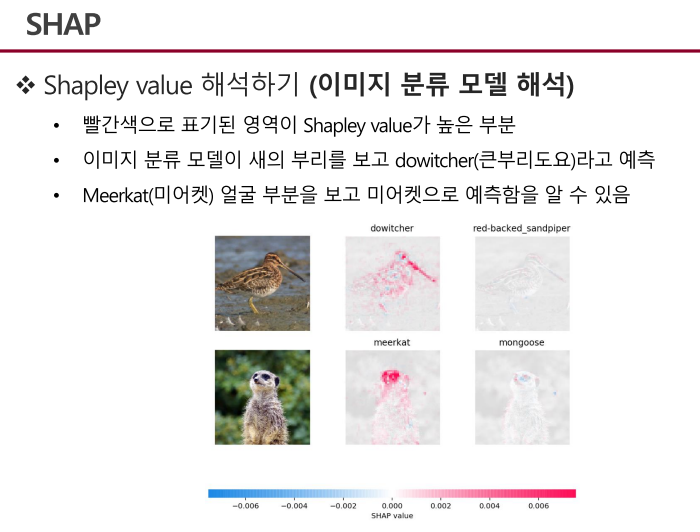

In [18]:
""" 설명 장표 불러오기 """
from IPython.display import Image
Image('image/9-XAI6.PNG') ### 로컬 사용 시
# Image('/content/2025-LGElec-Day22/image/9-XAI6.PNG') ### colab 사용 시

#### **4-1. GradientShap**

 - 각 Feature의 Gradient에 기여한 정도에 따라 구분

In [19]:
""" Shap Value 측정 """

device = 'cuda' if torch.cuda.is_available() else 'cpu'
explainer = shap.GradientExplainer(model=(model, model.features[7]), ### Index7 Feature에 기여여부로 파악
                                   data=normalize(X).to(device)) 

shap_values_tensor, indexes = explainer.shap_values(X=normalize(test_imgs).to(device),
                                            ranked_outputs=2) ### 최대 예측 확률 두 가지 Class에 대해 Shap Value 산출
print(shap_values_tensor.shape) ### (column(rank), channel, width, height, row(=batch))
print(indexes)

(2, 128, 112, 112, 2)
tensor([[142, 140],
        [299, 298]], device='cuda:0')


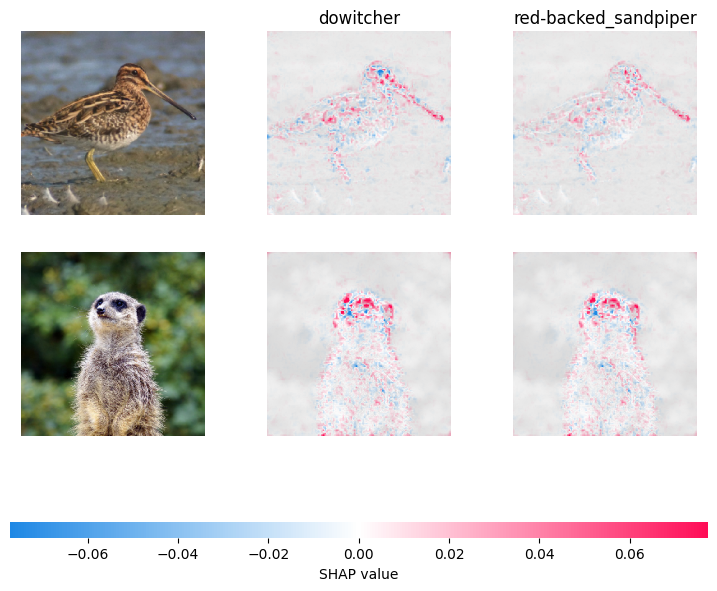

In [20]:
""" Shap Value 시각화"""

### Class명 할당
index_names = np.vectorize(lambda x: class_idx[str(x)][1])(indexes.cpu())

### Shap Value 조정
shap_values_tensor = np.swapaxes(shap_values_tensor, 0, -1) ### batch <-> rank swap
shap_values = [np.swapaxes(s, 0, 3) for s in shap_values_tensor] ### channel <-> rank swap --> [(rank, h, w, c), (rank, h, w, c)]

### 시각화
shap.image_plot(shap_values, test_imgs/255., index_names)

#### **4-2. PartitionShap**

 - 픽셀보다 큰 범위에서 Shap 연산 수행 (계산비용 절감 가능)

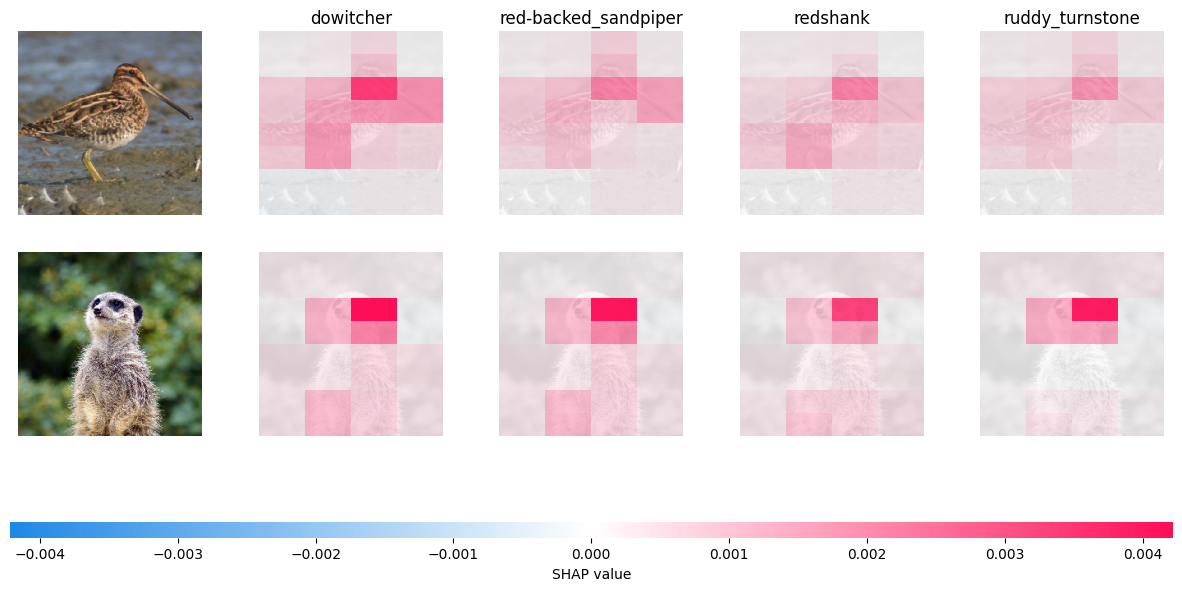

In [21]:
""" Shap Value 측정 및 시각화 (1) """

### Shap Value 측정을 위한 모델 함수 정의
def model_prediction(imgs):
    tmp = imgs.copy()
    tmp = normalize(imgs)
    tmp = tmp.to(device)
    return model(tmp)

### Shap Value 연산
masker = shap.maskers.Image("inpaint_telea", X[0].shape) ### 모델에 가중치 표시 방법
explainer = shap.Explainer(model_prediction, masker, output_names=idx2label)
shap_values = explainer(test_imgs, max_evals=100, outputs=shap.Explanation.argsort.flip[:4]) ### max_evals: 게임이론에서 최대 연산 횟수 / outputs: argsort(확률이 낮은 순으로 정렬) -> flip(높은 순으로 정렬) --> [:4] 최대 4개 확률 확인

### 시각화
shap.image_plot(shap_values, test_imgs/255.)

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 3it [00:42, 21.36s/it]               


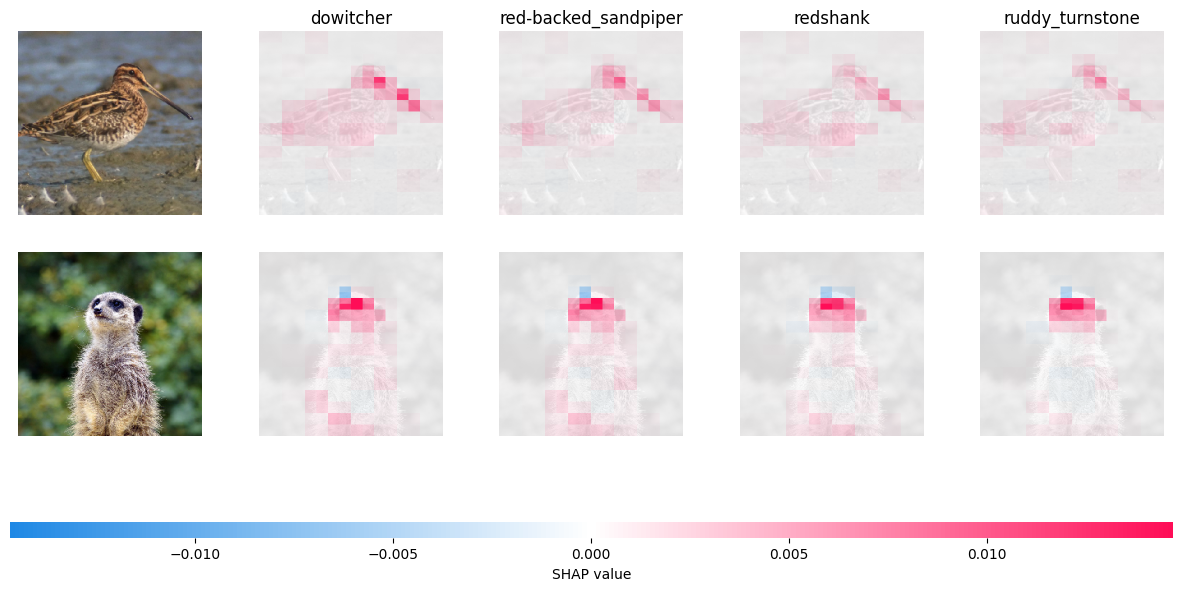

In [22]:
""" Shap Value 측정 및 시각화 (2) """

### Shap Value 연산
masker = shap.maskers.Image("blur(128,128)", X[0].shape) ### 모델에 가중치 표시 방법
explainer = shap.Explainer(model_prediction, masker, output_names=idx2label)
shap_values = explainer(test_imgs, max_evals=5000, outputs=shap.Explanation.argsort.flip[:4]) ### max_evals가 크면 조밀한 픽셀 고려 가능

### 시각화
shap.image_plot(shap_values, test_imgs/255.)